#  Clustering Robustness under Poisoning Attacks on the Iris Dataset

This notebook explores the **impact of data poisoning on clustering performance** using the **Iris dataset**. The primary objective is to understand how injecting adversarial or synthetic samples can **blur cluster boundaries**, potentially degrading the quality of clustering models.

###  Objectives:
- Apply different **data poisoning techniques** (e.g., centroid-based noise, inter-cluster bridge samples).
- Analyze how **varying percentages of poisoned data (0% to 50%)** affect clustering outcomes.
- Visualize original vs. poisoned clusters side by side.

###  Dataset:
- **Iris Dataset** (scaled)
- Contains 150 samples of iris flowers across 3 species with 4 features:
  - Sepal length, Sepal width, Petal length, Petal width

###  Clustering Method:
- **KMeans** with 3 clusters (matching the known Iris species)

### Poisoning Techniques:
- **Bridge-based Poisoning**: Interpolated points between two closest clusters
- **Centroid-based Poisoning**: Synthetic noise samples generated near cluster centroids
- **Noise Percentage Variants**: 0%, 5%, 10%, 20%, 30%, 40%, 50%

###  Evaluation Metrics:
Each clustering output is assessed using the following metrics:
- **Silhouette Score** (higher is better)
- **Davies-Bouldin Index** (lower is better)
- **Calinski-Harabasz Score** (higher is better)
- **Adjusted Rand Index (ARI)** vs. true labels (higher is better)
- **Classification Report** (for cluster-to-class alignment)

###  Summary:
This notebook provides **visual analysis**, **quantitative evaluation**, and **metric tracking** to compare the robustness of clustering under different poisoning levels. It aims to demonstrate the vulnerability of unsupervised learning to input manipulation and offer insights for potential defense strategies.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import classification_report
from scipy.stats import mode

#Creating synthetic noise around the centroids

###1. Load original data

In [2]:
iris = load_iris()
X = iris['data']
y = iris['target']
feature_names = iris['feature_names']
feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [3]:
labels = iris.target_names.tolist()
labels

['setosa', 'versicolor', 'virginica']

### 2. Analyze feature strength

In [4]:
df = pd.DataFrame(X, columns=feature_names)
print(df.describe())

       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  
count        150.000000  
mean           1.199333  
std            0.762238  
min            0.100000  
25%            0.300000  
50%            1.300000  
75%            1.800000  
max            2.500000  


### 3. Scale the data

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 4. Cluster original data

In [6]:
kmeans = KMeans(n_clusters=3, random_state=42)
original_labels = kmeans.fit_predict(X_scaled)

### 5. Create synthetic noise

-It creates fake samples around the center of the real data.

-It adds more disturbance to the important features (petal measurements).

-It adds little disturbance to the less important features (sepal measurements).

-The goal is to confuse clustering without making it look completely unrealistic.

In [7]:
def create_synthetic_noise(X, n_samples=20, noise_strength=0.5):
    np.random.seed(42)
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)

    noise = np.random.randn(n_samples, X.shape[1])

    # Sophisticated blending:
    # - Strong features (petal length, width) -> add bigger noise
    # - Weak features (sepal width) -> mild noise

    noise[:, [2,3]] *= noise_strength * 2  # petal length and petal width
    noise[:, [0,1]] *= noise_strength * 0.5  # sepal length and width

    synthetic_points = X_mean + noise * X_std
    return synthetic_points

synthetic_data = create_synthetic_noise(X_scaled, n_samples=20, noise_strength=0.5)

### 6. Combine original + synthetic noise

In [8]:
X_poisoned = np.vstack([X_scaled, synthetic_data])

### 7. Cluster poisoned data

In [9]:
kmeans_poisoned = KMeans(n_clusters=3, random_state=42)
poisoned_labels = kmeans_poisoned.fit_predict(X_poisoned)

### 8. Define evaluation function

In [10]:
def evaluate_clustering(X, labels, true_labels=None):
    scores = {}

    scores['Silhouette Score'] = silhouette_score(X, labels)
    scores['Davies-Bouldin Index'] = davies_bouldin_score(X, labels)
    scores['Calinski-Harabasz Score'] = calinski_harabasz_score(X, labels)

    if true_labels is not None:
        scores['Adjusted Rand Index'] = adjusted_rand_score(true_labels, labels)

    return scores

### 9. Evaluate both clustering results

In [11]:
print("\n=== Evaluation Metrics ===\n")

print("Original Clustering Metrics:")
original_scores = evaluate_clustering(X_scaled, original_labels, y)
for metric, value in original_scores.items():
    print(f"{metric}: {value:.4f}")

print("\nPoisoned Clustering Metrics:")
poisoned_scores = evaluate_clustering(X_poisoned, poisoned_labels, np.concatenate([y, [-1]*len(synthetic_data)]))
for metric, value in poisoned_scores.items():
    print(f"{metric}: {value:.4f}")

#Table view

metrics_table = pd.DataFrame({
    "Original": original_scores,
    "Poisoned": poisoned_scores
})
print("\nMetrics Table:\n", metrics_table)


=== Evaluation Metrics ===

Original Clustering Metrics:
Silhouette Score: 0.4799
Davies-Bouldin Index: 0.7894
Calinski-Harabasz Score: 157.3602
Adjusted Rand Index: 0.4328

Poisoned Clustering Metrics:
Silhouette Score: 0.4071
Davies-Bouldin Index: 1.0142
Calinski-Harabasz Score: 144.6544
Adjusted Rand Index: 0.3454

Metrics Table:
                            Original    Poisoned
Silhouette Score           0.479881    0.407100
Davies-Bouldin Index       0.789363    1.014190
Calinski-Harabasz Score  157.360153  144.654410
Adjusted Rand Index        0.432805    0.345357


### 10. Visualize clusters

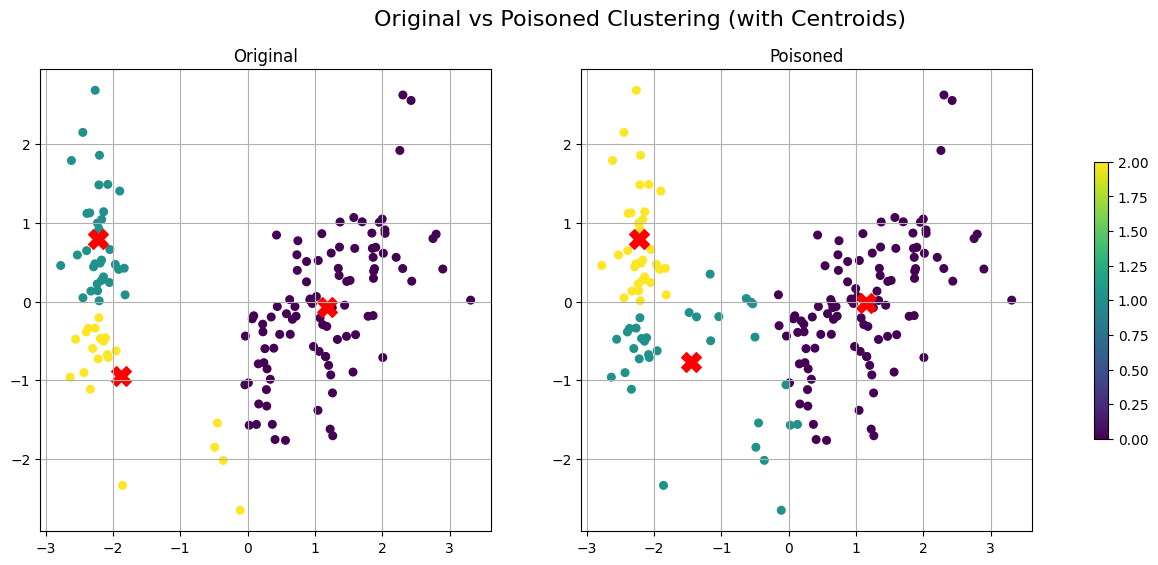

In [12]:
def plot_clusters_side_by_side(X1, labels1, X2, labels2, title1="Original", title2="Poisoned"):
    pca = PCA(n_components=2)
    X1_2d = pca.fit_transform(X1)
    X2_2d = pca.transform(X2)

    # Fit KMeans to both datasets to get centroids
    kmeans1 = KMeans(n_clusters=3, random_state=42).fit(X1)
    kmeans2 = KMeans(n_clusters=3, random_state=42).fit(X2)

    # Project centroids to 2D using PCA
    centroids1_2d = pca.transform(kmeans1.cluster_centers_)
    centroids2_2d = pca.transform(kmeans2.cluster_centers_)

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    sc1 = axs[0].scatter(X1_2d[:, 0], X1_2d[:, 1], c=labels1, cmap='viridis', s=30)
    axs[0].scatter(centroids1_2d[:, 0], centroids1_2d[:, 1], c='red', marker='X', s=200, label='Centroids')
    axs[0].set_title(title1)
    axs[0].grid(True)

    sc2 = axs[1].scatter(X2_2d[:, 0], X2_2d[:, 1], c=labels2, cmap='viridis', s=30)
    axs[1].scatter(centroids2_2d[:, 0], centroids2_2d[:, 1], c='red', marker='X', s=200, label='Centroids')
    axs[1].set_title(title2)
    axs[1].grid(True)

    plt.colorbar(sc2, ax=axs.ravel().tolist(), shrink=0.6)
    plt.suptitle('Original vs Poisoned Clustering (with Centroids)', fontsize=16)
    plt.show()

plot_clusters_side_by_side(X_scaled, original_labels, X_poisoned, poisoned_labels)


#Creating synthetic noise between two culsters to blur the borders

### 1. Find centroids of original clusters

In [13]:
centroids = []
for label in np.unique(original_labels):
    cluster_points = X_scaled[original_labels == label]
    centroids.append(cluster_points.mean(axis=0))
centroids = np.array(centroids)

### 2. Find the closest pair of clusters

In [14]:
centroid_distances = cdist(centroids, centroids)
np.fill_diagonal(centroid_distances, np.inf)  # ignore self-distances
i, j = np.unravel_index(np.argmin(centroid_distances), centroid_distances.shape)
print(f"Closest clusters: {i} and {j}")

Closest clusters: 1 and 2


 ### 3. Create synthetic samples between the two closest clusters

Bridge samples are synthetic points created between two close clusters to confuse the clustering model.

In [15]:
def create_bridge_samples(X_scaled, label_i, label_j, n_samples=20, noise_strength=0.3):
    points_i = X_scaled[original_labels == label_i]
    points_j = X_scaled[original_labels == label_j]

    bridge_samples = []
    np.random.seed(42)

    for _ in range(n_samples):
        p1 = points_i[np.random.randint(len(points_i))]
        p2 = points_j[np.random.randint(len(points_j))]

        # Interpolate + small noise
        alpha = np.random.uniform(0.3, 0.7)  # weighted average (not exactly midpoint)
        bridge_point = alpha * p1 + (1 - alpha) * p2

        noise = np.random.randn(*bridge_point.shape) * noise_strength
        bridge_point += noise

        bridge_samples.append(bridge_point)

    return np.array(bridge_samples)

bridge_noise = create_bridge_samples(X_scaled, i, j, n_samples=20, noise_strength=0.2)

### 4. Merge into poisoned dataset

In [16]:
X_poisoned_bridge = np.vstack([X_scaled, bridge_noise])

### 5. Cluster the poisoned data

We re-run KMeans on the poisoned data to see how the cluster boundaries change.

In [18]:
# Original clustering metrics
kmeans_original = KMeans(n_clusters=3, random_state=42)
original_labels_kmeans = kmeans_original.fit_predict(X_scaled)

original_silhouette = silhouette_score(X_scaled, original_labels_kmeans)
original_db = davies_bouldin_score(X_scaled, original_labels_kmeans)
original_ch = calinski_harabasz_score(X_scaled, original_labels_kmeans)
original_ari = adjusted_rand_score(y, original_labels_kmeans)

# Poisoned clustering metrics
kmeans_poisoned_bridge = KMeans(n_clusters=3, random_state=42)
poisoned_labels_bridge = kmeans_poisoned_bridge.fit_predict(X_poisoned_bridge)

poisoned_silhouette = silhouette_score(X_poisoned_bridge, poisoned_labels_bridge)
poisoned_db = davies_bouldin_score(X_poisoned_bridge, poisoned_labels_bridge)
poisoned_ch = calinski_harabasz_score(X_poisoned_bridge, poisoned_labels_bridge)
poisoned_ari = adjusted_rand_score(
    np.concatenate([y, [-1]*len(bridge_noise)]),
    poisoned_labels_bridge
)

# Create comparison table
metrics_df = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Score', 'Adjusted Rand Index'],
    'Original': [original_silhouette, original_db, original_ch, original_ari],
    'Poisoned (Bridge)': [poisoned_silhouette, poisoned_db, poisoned_ch, poisoned_ari]
})

print("\nClustering Metrics Comparison:")
print(metrics_df.round(4))


Clustering Metrics Comparison:
                    Metric  Original  Poisoned (Bridge)
0         Silhouette Score    0.4799             0.4741
1     Davies-Bouldin Index    0.7894             0.8270
2  Calinski-Harabasz Score  157.3602           291.1677
3      Adjusted Rand Index    0.4328             0.5600


### 6. Visualization

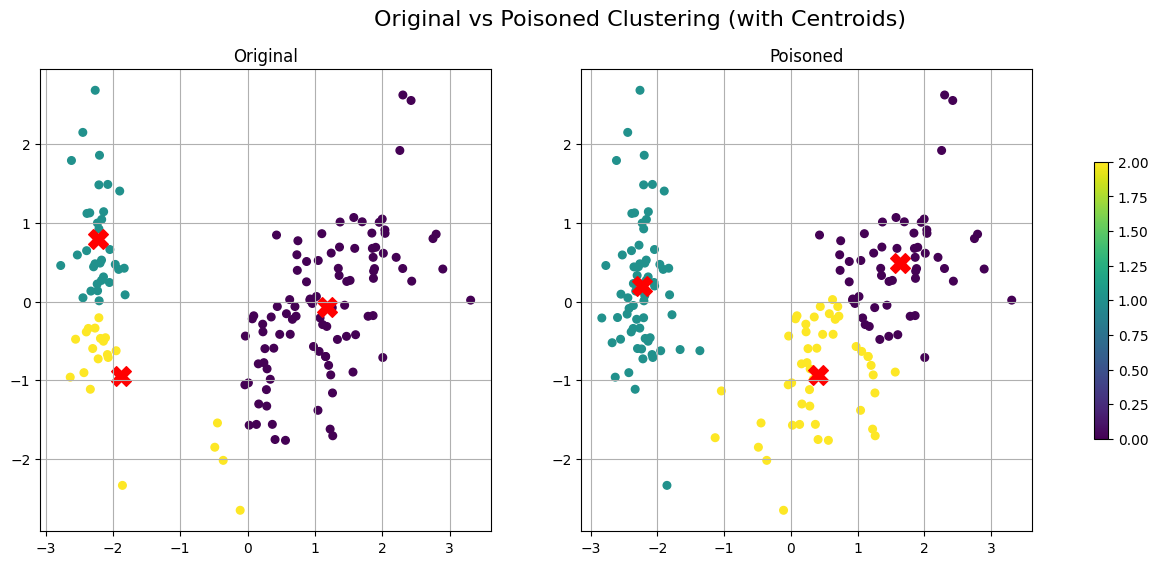

In [19]:
plot_clusters_side_by_side(X_scaled, original_labels, X_poisoned_bridge, poisoned_labels_bridge)


##Changing the amounts of noise to see which amout would be great for poisoning

### 7. Noise scheduler: add different amounts of noise and track metrics

In [20]:
def noise_scheduler(X_clean, y_clean, noise_levels=[0, 5, 10, 20, 30, 40, 50], noise_strength=0.5):
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []
    ari_scores = []

    for noise_pct in noise_levels:
        if noise_pct == 0:
            X_combined = X_clean
            y_combined = y_clean
        else:
            n_samples = int(len(X_clean) * noise_pct / 100)
            synthetic_noise = create_synthetic_noise(X_clean, n_samples=n_samples, noise_strength=noise_strength)
            X_combined = np.vstack([X_clean, synthetic_noise])
            y_combined = np.concatenate([y_clean, [-1]*n_samples])

        # Cluster
        kmeans = KMeans(n_clusters=3, random_state=42)
        cluster_labels = kmeans.fit_predict(X_combined)

        # Evaluate
        silhouette = silhouette_score(X_combined, cluster_labels)
        db_index = davies_bouldin_score(X_combined, cluster_labels)
        ch_score = calinski_harabasz_score(X_combined, cluster_labels)
        ari = adjusted_rand_score(y_combined, cluster_labels)

        silhouette_scores.append(silhouette)
        davies_bouldin_scores.append(db_index)
        calinski_harabasz_scores.append(ch_score)
        ari_scores.append(ari)

    return {
        "noise_levels": noise_levels,
        "silhouette": silhouette_scores,
        "davies_bouldin": davies_bouldin_scores,
        "calinski_harabasz": calinski_harabasz_scores,
        "ari": ari_scores
    }


noise_results = noise_scheduler(X_scaled, y, noise_levels=[0, 5, 10, 20, 30, 40, 50])

### 8. Plot results

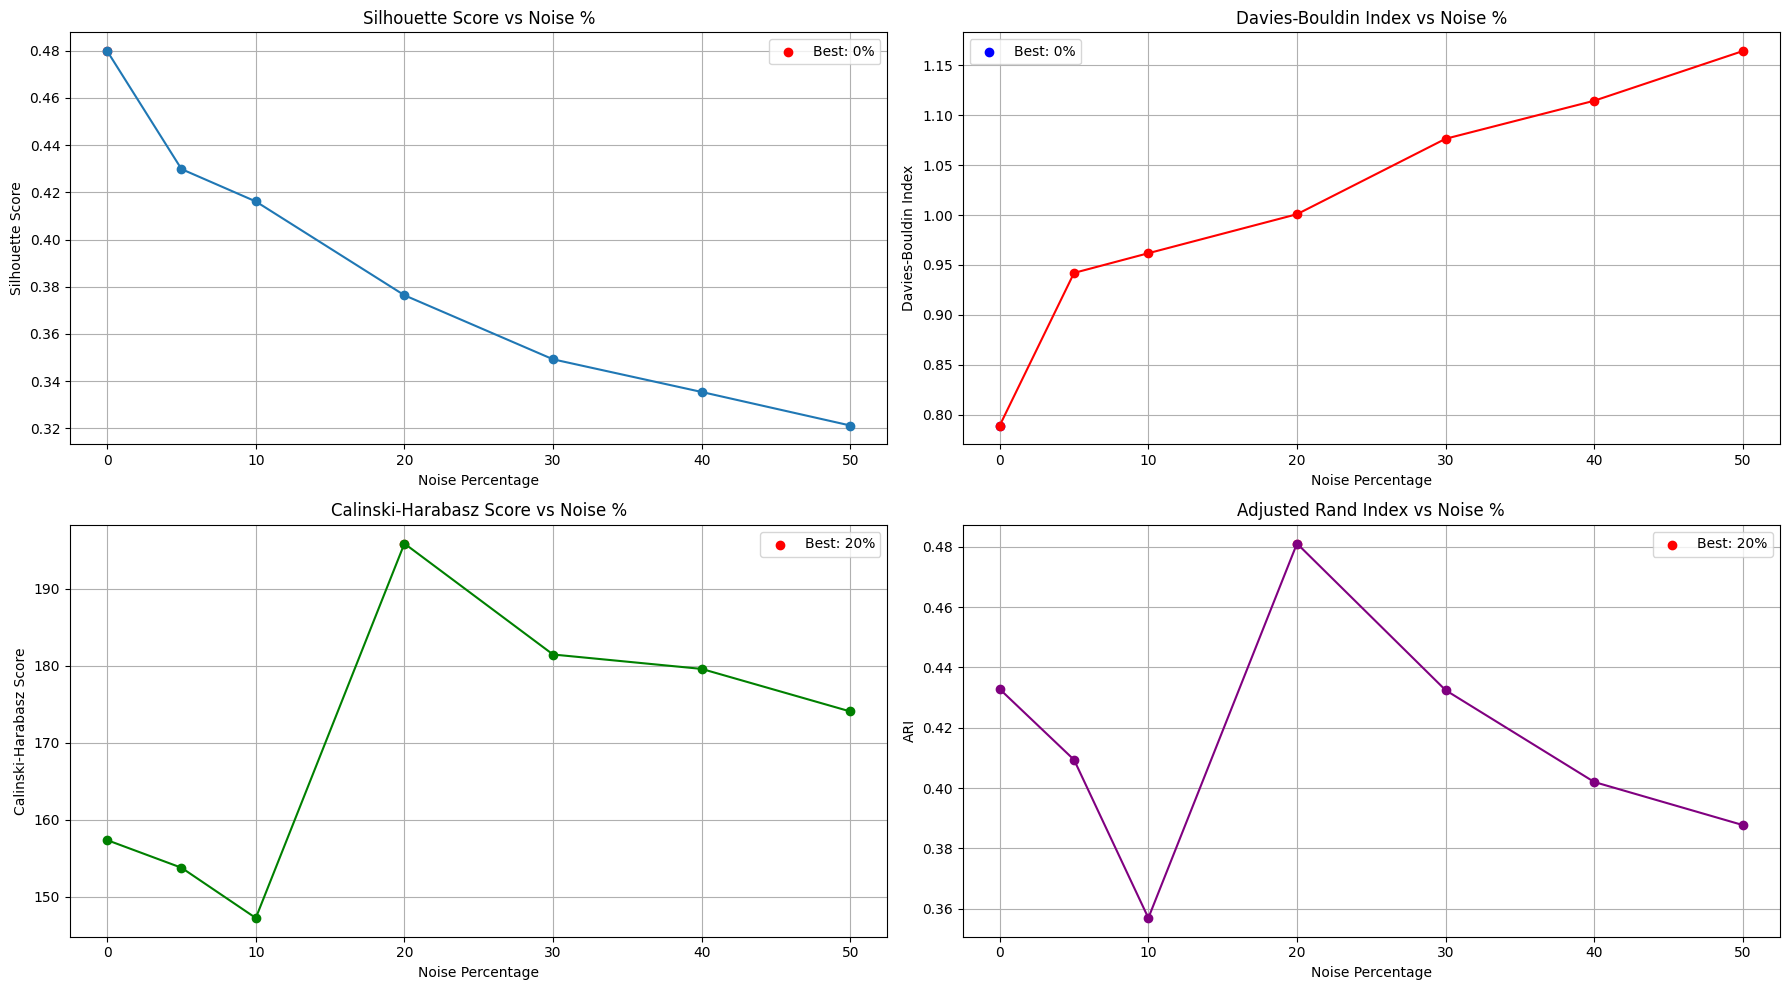

Best Silhouette Score at 0% noise: 0.4799
Best (lowest) Davies-Bouldin Index at 0% noise: 0.7894
Best Calinski-Harabasz Score at 20% noise: 195.8450
Best ARI at 20% noise: 0.4811


In [21]:
def plot_metrics_over_noise(noise_results):
    noise_levels = noise_results['noise_levels']

    # Find best noise levels
    best_silhouette_idx = np.argmax(noise_results['silhouette'])
    best_davies_idx = np.argmin(noise_results['davies_bouldin'])
    best_calinski_idx = np.argmax(noise_results['calinski_harabasz'])
    best_ari_idx = np.argmax(noise_results['ari'])

    plt.figure(figsize=(18,10))

    # Silhouette
    plt.subplot(2,2,1)
    plt.plot(noise_levels, noise_results['silhouette'], marker='o')
    plt.scatter(noise_levels[best_silhouette_idx], noise_results['silhouette'][best_silhouette_idx],
                color='red', label=f'Best: {noise_levels[best_silhouette_idx]}%')
    plt.title('Silhouette Score vs Noise %')
    plt.xlabel('Noise Percentage')
    plt.ylabel('Silhouette Score')
    plt.legend()
    plt.grid(True)

    # Davies-Bouldin
    plt.subplot(2,2,2)
    plt.plot(noise_levels, noise_results['davies_bouldin'], marker='o', color='red')
    plt.scatter(noise_levels[best_davies_idx], noise_results['davies_bouldin'][best_davies_idx],
                color='blue', label=f'Best: {noise_levels[best_davies_idx]}%')
    plt.title('Davies-Bouldin Index vs Noise %')
    plt.xlabel('Noise Percentage')
    plt.ylabel('Davies-Bouldin Index')
    plt.legend()
    plt.grid(True)

    # Calinski-Harabasz
    plt.subplot(2,2,3)
    plt.plot(noise_levels, noise_results['calinski_harabasz'], marker='o', color='green')
    plt.scatter(noise_levels[best_calinski_idx], noise_results['calinski_harabasz'][best_calinski_idx],
                color='red', label=f'Best: {noise_levels[best_calinski_idx]}%')
    plt.title('Calinski-Harabasz Score vs Noise %')
    plt.xlabel('Noise Percentage')
    plt.ylabel('Calinski-Harabasz Score')
    plt.legend()
    plt.grid(True)

    # Adjusted Rand Index
    plt.subplot(2,2,4)
    plt.plot(noise_levels, noise_results['ari'], marker='o', color='purple')
    plt.scatter(noise_levels[best_ari_idx], noise_results['ari'][best_ari_idx],
                color='red', label=f'Best: {noise_levels[best_ari_idx]}%')
    plt.title('Adjusted Rand Index vs Noise %')
    plt.xlabel('Noise Percentage')
    plt.ylabel('ARI')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print bests
    print(f"Best Silhouette Score at {noise_levels[best_silhouette_idx]}% noise: {noise_results['silhouette'][best_silhouette_idx]:.4f}")
    print(f"Best (lowest) Davies-Bouldin Index at {noise_levels[best_davies_idx]}% noise: {noise_results['davies_bouldin'][best_davies_idx]:.4f}")
    print(f"Best Calinski-Harabasz Score at {noise_levels[best_calinski_idx]}% noise: {noise_results['calinski_harabasz'][best_calinski_idx]:.4f}")
    print(f"Best ARI at {noise_levels[best_ari_idx]}% noise: {noise_results['ari'][best_ari_idx]:.4f}")

plot_metrics_over_noise(noise_results)


##Experiencing with the dataset and adding different percentage noise between two clusters and analizing the results

The data is reloaded again, just to make sure it is the clean dataset and not some already poisoned one

### 1. Load data

In [22]:
iris = load_iris()
X = iris['data']
y = iris['target']
feature_names = iris['feature_names']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cluster original data
kmeans = KMeans(n_clusters=3, random_state=42)
original_labels = kmeans.fit_predict(X_scaled)

###2. Find closest pair of clusters

In [23]:
centroids = []
for label in np.unique(original_labels):
    cluster_points = X_scaled[original_labels == label]
    centroids.append(cluster_points.mean(axis=0))
centroids = np.array(centroids)

centroid_distances = cdist(centroids, centroids)
np.fill_diagonal(centroid_distances, np.inf)
i, j = np.unravel_index(np.argmin(centroid_distances), centroid_distances.shape)

print(f"Closest clusters found: {i} and {j}")

Closest clusters found: 1 and 2


###3. Function to create synthetic "bridge" points between two clusters

In [24]:
def create_bridge_samples(X_scaled, original_labels, label_i, label_j, n_samples=20, noise_strength=0.2):
    points_i = X_scaled[original_labels == label_i]
    points_j = X_scaled[original_labels == label_j]

    bridge_samples = []
    np.random.seed(42)

    for _ in range(n_samples):
        p1 = points_i[np.random.randint(len(points_i))]
        p2 = points_j[np.random.randint(len(points_j))]

        alpha = np.random.uniform(0.3, 0.7)
        bridge_point = alpha * p1 + (1 - alpha) * p2

        noise = np.random.randn(*bridge_point.shape) * noise_strength
        bridge_point += noise

        bridge_samples.append(bridge_point)

    return np.array(bridge_samples)

###4. Evaluation function

In [25]:
def evaluate_clustering(X, labels, true_labels=None):
    scores = {}
    scores['Silhouette Score'] = silhouette_score(X, labels)
    scores['Davies-Bouldin Index'] = davies_bouldin_score(X, labels)
    scores['Calinski-Harabasz Score'] = calinski_harabasz_score(X, labels)
    if true_labels is not None:
        scores['Adjusted Rand Index'] = adjusted_rand_score(true_labels, labels)
    return scores

###5. Match clusters by minimizing centroid distances

In [26]:
def match_clusters_2(true_labels, predicted_labels):
    new_labels = np.zeros_like(predicted_labels)
    for cluster in np.unique(predicted_labels):
        mask = predicted_labels == cluster
        majority_candidates = true_labels[mask]
        majority_candidates = majority_candidates[majority_candidates != -1]  # Filter out -1
        if len(majority_candidates) > 0:
            most_common = mode(majority_candidates, keepdims=True).mode[0]
            new_labels[mask] = most_common
        else:
            # Assign a default or keep the label (optional)
            new_labels[mask] = -1
    return new_labels



###6. Visualization function

We apply the same PCA transformation and same color mapping to ensure visual comparability

In [27]:
def plot_clusters_side_by_side(X1, labels1, X2, labels2, title1="Original", title2="Poisoned"):
    pca = PCA(n_components=2)
    X1_2d = pca.fit_transform(X1)
    X2_2d = pca.transform(X2)

    fig, axs = plt.subplots(1, 2, figsize=(16,6))

    sc1 = axs[0].scatter(X1_2d[:,0], X1_2d[:,1], c=labels1, cmap='viridis', s=30)
    axs[0].set_title(title1)
    axs[0].grid(True)

    sc2 = axs[1].scatter(X2_2d[:,0], X2_2d[:,1], c=labels2, cmap='viridis', s=30)
    axs[1].set_title(title2)
    axs[1].grid(True)

    plt.colorbar(sc2, ax=axs.ravel().tolist(), shrink=0.6)
    plt.suptitle(f'Original vs Poisoned Clustering', fontsize=16)
    plt.show()

###7. Poisoning percentages to test


=== Poisoning 0% ===
Silhouette Score: 0.4799
Davies-Bouldin Index: 0.7894
Calinski-Harabasz Score: 157.3602
Adjusted Rand Index: 0.4328


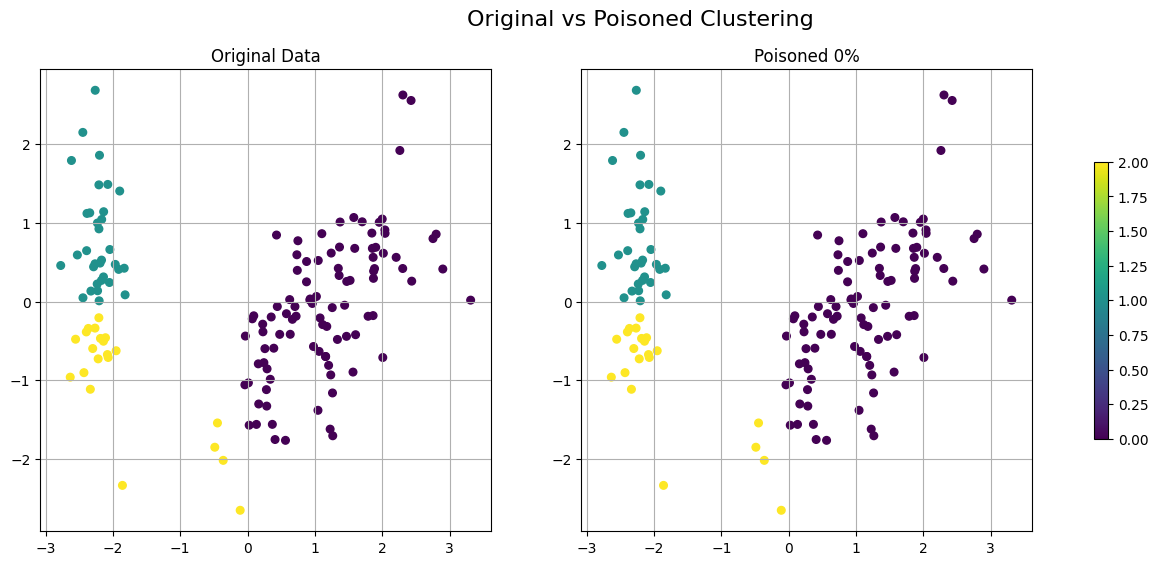


=== Poisoning 5% ===
Silhouette Score: 0.5707
Davies-Bouldin Index: 0.6302
Calinski-Harabasz Score: 266.7693
Adjusted Rand Index: 0.5084


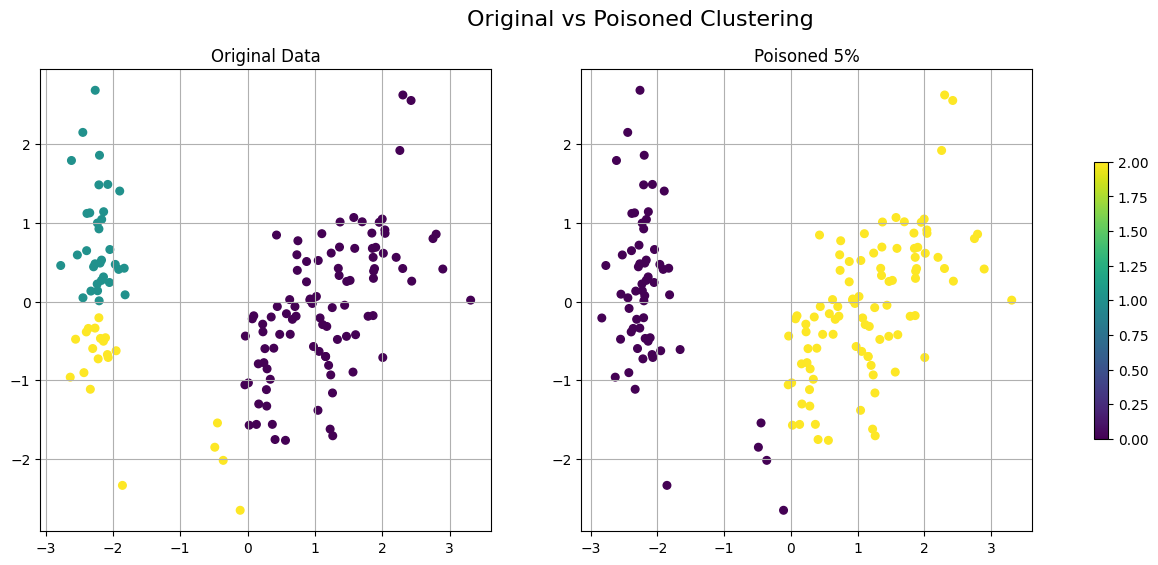


=== Poisoning 10% ===
Silhouette Score: 0.5938
Davies-Bouldin Index: 0.5808
Calinski-Harabasz Score: 316.6101
Adjusted Rand Index: 0.5277


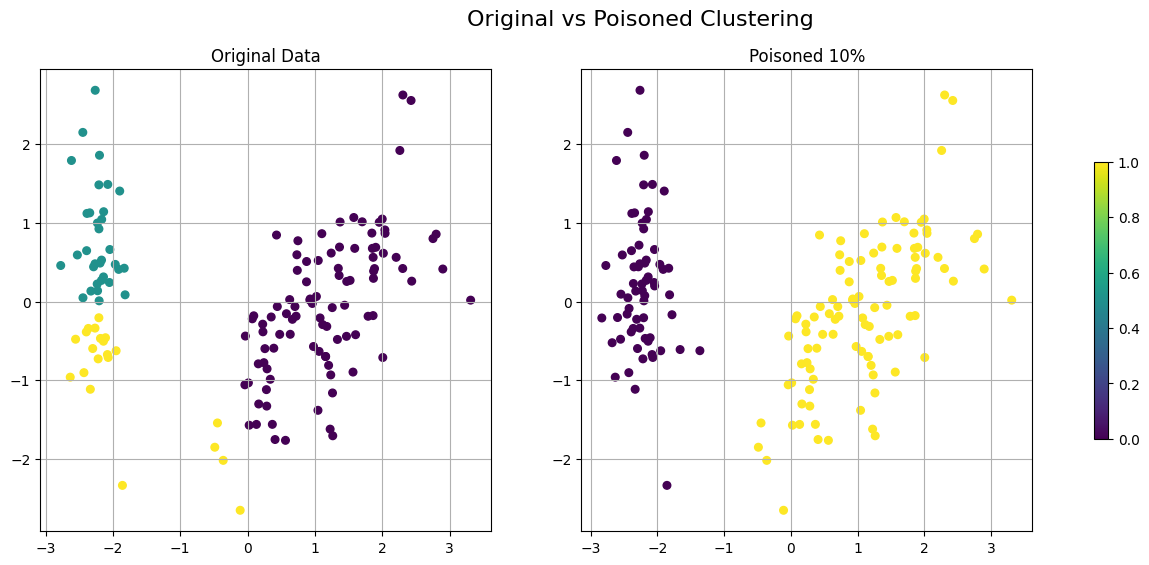


=== Poisoning 20% ===
Silhouette Score: 0.4739
Davies-Bouldin Index: 0.8331
Calinski-Harabasz Score: 303.2164
Adjusted Rand Index: 0.5273


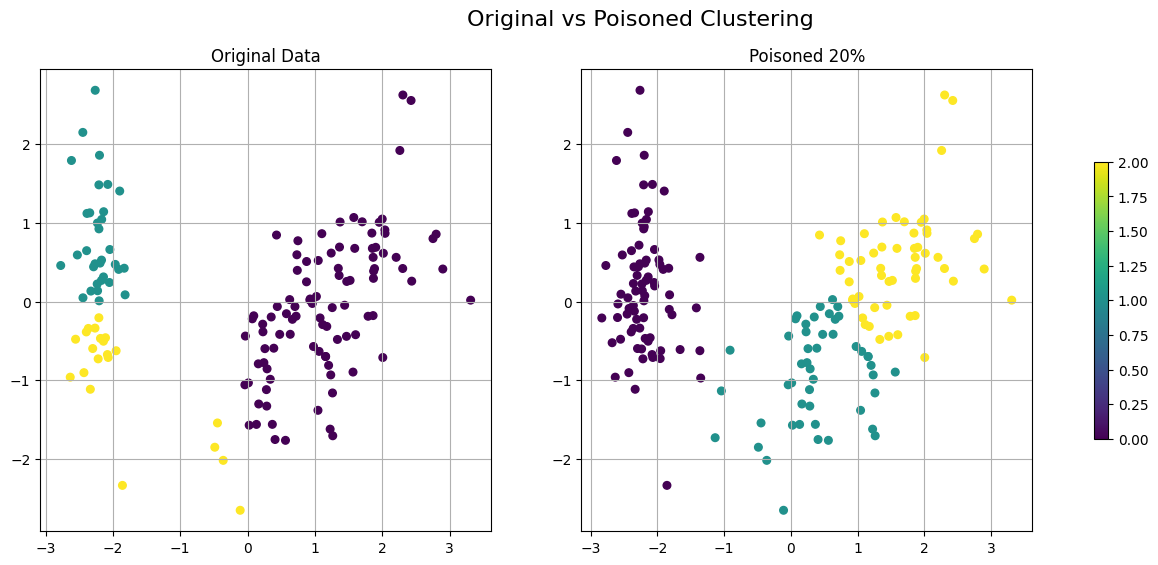


=== Poisoning 30% ===
Silhouette Score: 0.5765
Davies-Bouldin Index: 0.6295
Calinski-Harabasz Score: 368.9278
Adjusted Rand Index: 0.4579


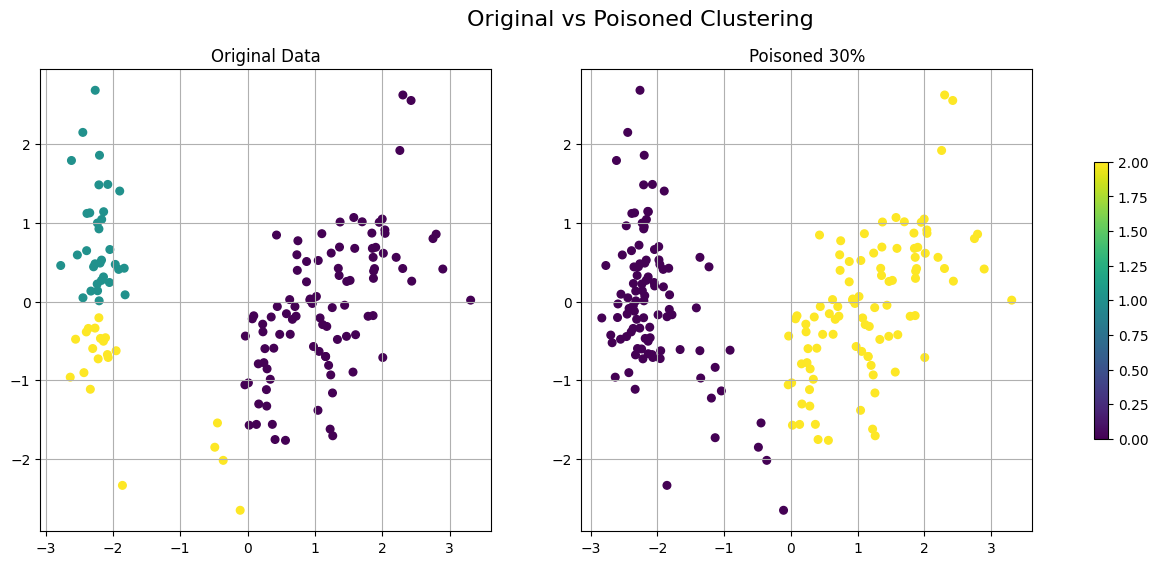


=== Poisoning 40% ===
Silhouette Score: 0.4868
Davies-Bouldin Index: 0.8276
Calinski-Harabasz Score: 345.8864
Adjusted Rand Index: 0.4712


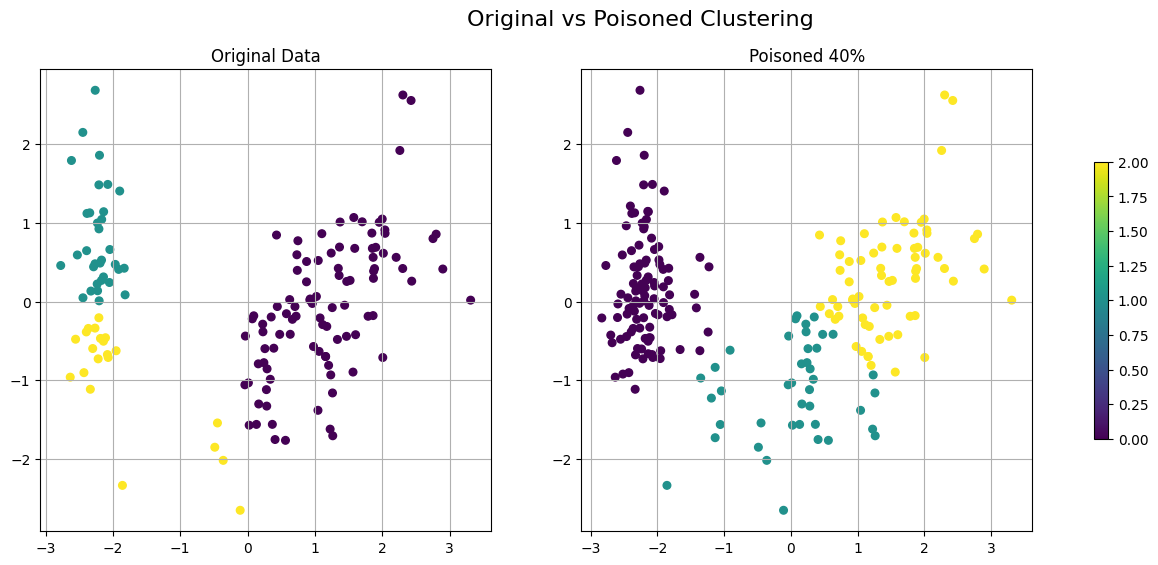


=== Poisoning 50% ===
Silhouette Score: 0.4908
Davies-Bouldin Index: 0.8358
Calinski-Harabasz Score: 369.6886
Adjusted Rand Index: 0.4839


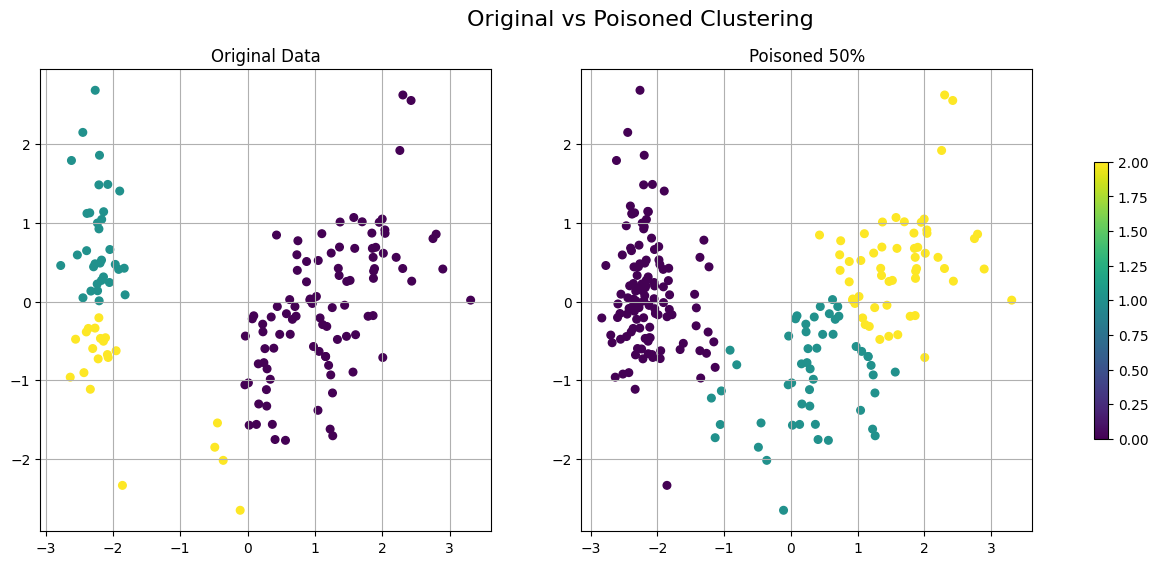

In [28]:
poisoning_percentages = [0, 5, 10, 20, 30, 40, 50]
metrics_overall = {
    'Poisoning %': [],
    'Silhouette Score': [],
    'Davies-Bouldin Index': [],
    'Calinski-Harabasz Score': [],
    'Adjusted Rand Index': []
}

# Dictionary to store classification reports by percentage
classification_reports_named = {}

for percentage in poisoning_percentages:
    print(f"\n=== Poisoning {percentage}% ===")

    n_samples = int(percentage / 100 * len(X_scaled))

    if percentage == 0 or n_samples == 0:
        X_poisoned = X_scaled
        y_poisoned = y
        poisoned_labels = original_labels
    else:
        bridge_samples = create_bridge_samples(X_scaled, original_labels, i, j, n_samples=n_samples, noise_strength=0.2)

        X_poisoned = np.vstack([X_scaled, bridge_samples])
        y_poisoned = np.concatenate([y, [-1]*len(bridge_samples)])

        kmeans_poisoned = KMeans(n_clusters=3, random_state=42)
        poisoned_labels = kmeans_poisoned.fit_predict(X_poisoned)

        # Align clusters to fix color
        poisoned_labels = match_clusters_2(y_poisoned, poisoned_labels)


    # Only evaluate on original samples
    original_mask = y_poisoned != -1
    y_true = y_poisoned[original_mask]
    y_pred = poisoned_labels[original_mask]

    #print(f"\n=== Classification Report for {percentage}% Poisoning ===")
    report_str = classification_report(y_true, y_pred, target_names=labels, zero_division=0)
    #print(report_str)
    classification_reports_named[percentage] = report_str

    # Metrics
    scores = evaluate_clustering(X_poisoned, poisoned_labels, true_labels=y_poisoned)
    for metric, value in scores.items():
        print(f"{metric}: {value:.4f}")

    # Save metrics
    metrics_overall['Poisoning %'].append(percentage)
    for metric in ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Score', 'Adjusted Rand Index']:
        metrics_overall[metric].append(scores[metric])

    # --- Save classification report ---
    #report = classification_report(y_poisoned, poisoned_labels, target_names=labels)
    #classification_reports[percentage] = report

    # Plot
    plot_clusters_side_by_side(X_scaled, original_labels, X_poisoned, poisoned_labels,
                                title1=f"Original Data",
                                title2=f"Poisoned {percentage}%")




In [29]:
for perc, report in classification_reports_named.items():
    print(f"\n=== Classification Report for {perc}% Poisoning ===")
    print(report)



=== Classification Report for 0% Poisoning ===
              precision    recall  f1-score   support

      setosa       0.00      0.00      0.00      50.0
  versicolor       0.00      0.00      0.00      50.0
   virginica       0.00      0.00      0.00      50.0

    accuracy                           0.00     150.0
   macro avg       0.00      0.00      0.00     150.0
weighted avg       0.00      0.00      0.00     150.0


=== Classification Report for 5% Poisoning ===
              precision    recall  f1-score   support

      setosa       0.93      1.00      0.96        50
  versicolor       0.00      0.00      0.00        50
   virginica       0.52      1.00      0.68        50

    accuracy                           0.67       150
   macro avg       0.48      0.67      0.55       150
weighted avg       0.48      0.67      0.55       150


=== Classification Report for 10% Poisoning ===
              precision    recall  f1-score   support

      setosa       1.00      1.00     

# Key Observations:

0% Poisoning

- All precision, recall, f1 = 0

- Accuracy = 0

- Indicates that the initial clustering failed completely — likely due to a mismatch between original_labels and predicted clusters.


5%, 10%, 30% Poisoning
- Accuracy = 67%, but with:

  - One class (either versicolor or virginica) completely misclassified.

  - Another class often showing perfect or near-perfect recall, meaning clusters are very skewed.

- Model is overfitting to some clusters and failing for others — possibly due to poisoned data causing cluster collapse or confusion.

20%, 40%, 50% Poisoning
- Accuracy = 84–86%, and balanced performance across all three classes.

- f1-scores are high, with no class being completely misclassified.

- Poisoning improved clustering — possibly because bridge samples helped KMeans better separate clusters.

##Visualizing the metric results

In [30]:
# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics_overall)

# Find best noise levels
best_noise_levels = {}

# Silhouette Score (Higher is better)
best_silhouette_idx = metrics_df['Silhouette Score'].idxmax()
best_noise_levels['Silhouette Score'] = metrics_df.loc[best_silhouette_idx, 'Poisoning %']

# Davies-Bouldin Index (Lower is better)
best_db_idx = metrics_df['Davies-Bouldin Index'].idxmin()
best_noise_levels['Davies-Bouldin Index'] = metrics_df.loc[best_db_idx, 'Poisoning %']

# Calinski-Harabasz Score (Higher is better)
best_ch_idx = metrics_df['Calinski-Harabasz Score'].idxmax()
best_noise_levels['Calinski-Harabasz Score'] = metrics_df.loc[best_ch_idx, 'Poisoning %']

# Adjusted Rand Index (Higher is better)
best_ari_idx = metrics_df['Adjusted Rand Index'].idxmax()
best_noise_levels['Adjusted Rand Index'] = metrics_df.loc[best_ari_idx, 'Poisoning %']

print("\nBest noise levels per metric:")
for metric, noise in best_noise_levels.items():
    print(f"{metric}: {noise}% poisoning")


Best noise levels per metric:
Silhouette Score: 10% poisoning
Davies-Bouldin Index: 10% poisoning
Calinski-Harabasz Score: 50% poisoning
Adjusted Rand Index: 10% poisoning


### Plot with best points marked

Sharp drops or rises in metric values indicate the model is struggling with cluster separation.

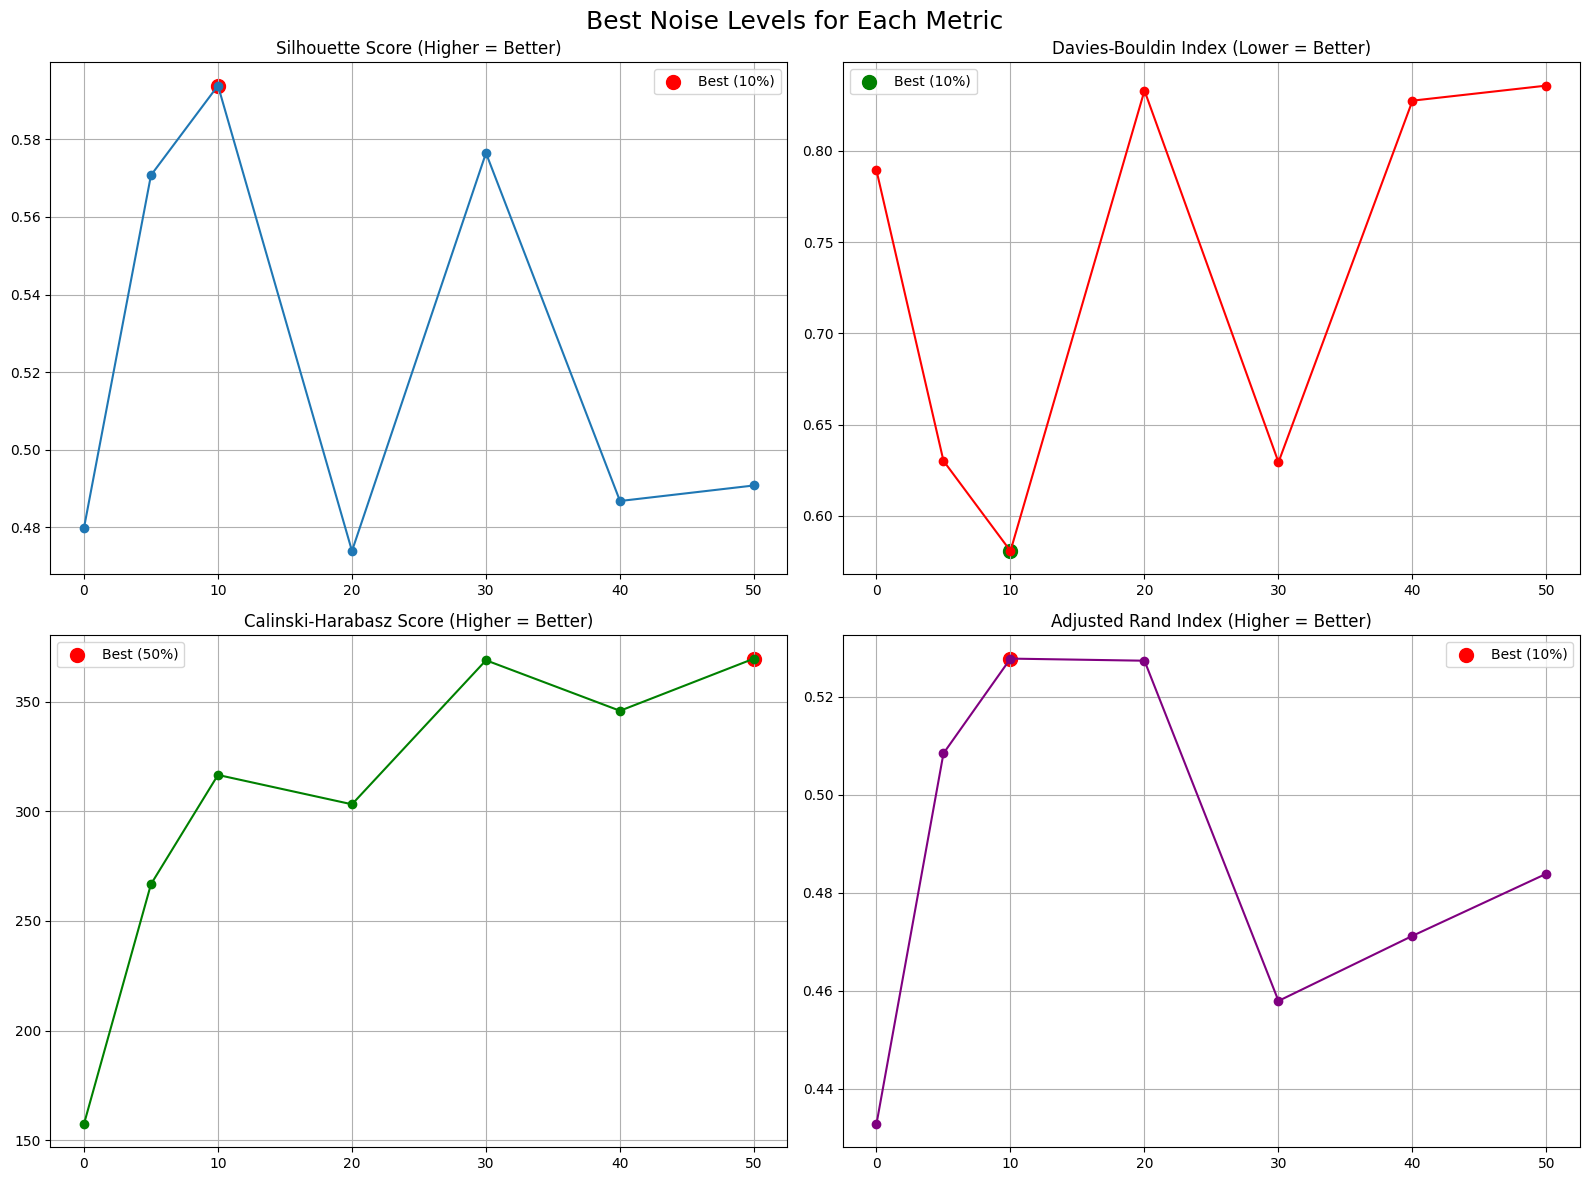

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Best Noise Levels for Each Metric', fontsize=18)

# 1. Silhouette
axs[0,0].plot(metrics_df['Poisoning %'], metrics_df['Silhouette Score'], marker='o')
axs[0,0].scatter(best_noise_levels['Silhouette Score'], metrics_df.loc[best_silhouette_idx, 'Silhouette Score'],
                 color='red', label=f"Best ({best_noise_levels['Silhouette Score']}%)", s=100)
axs[0,0].set_title('Silhouette Score (Higher = Better)')
axs[0,0].legend()
axs[0,0].grid(True)

# 2. Davies-Bouldin
axs[0,1].plot(metrics_df['Poisoning %'], metrics_df['Davies-Bouldin Index'], marker='o', color='r')
axs[0,1].scatter(best_noise_levels['Davies-Bouldin Index'], metrics_df.loc[best_db_idx, 'Davies-Bouldin Index'],
                 color='green', label=f"Best ({best_noise_levels['Davies-Bouldin Index']}%)", s=100)
axs[0,1].set_title('Davies-Bouldin Index (Lower = Better)')
axs[0,1].legend()
axs[0,1].grid(True)

# 3. Calinski-Harabasz
axs[1,0].plot(metrics_df['Poisoning %'], metrics_df['Calinski-Harabasz Score'], marker='o', color='g')
axs[1,0].scatter(best_noise_levels['Calinski-Harabasz Score'], metrics_df.loc[best_ch_idx, 'Calinski-Harabasz Score'],
                 color='red', label=f"Best ({best_noise_levels['Calinski-Harabasz Score']}%)", s=100)
axs[1,0].set_title('Calinski-Harabasz Score (Higher = Better)')
axs[1,0].legend()
axs[1,0].grid(True)

# 4. Adjusted Rand Index
axs[1,1].plot(metrics_df['Poisoning %'], metrics_df['Adjusted Rand Index'], marker='o', color='purple')
axs[1,1].scatter(best_noise_levels['Adjusted Rand Index'], metrics_df.loc[best_ari_idx, 'Adjusted Rand Index'],
                 color='red', label=f"Best ({best_noise_levels['Adjusted Rand Index']}%)", s=100)
axs[1,1].set_title('Adjusted Rand Index (Higher = Better)')
axs[1,1].legend()
axs[1,1].grid(True)

plt.tight_layout()
plt.show()



# Results Summary and Interpretation

## Noise Effect on Clustering

We introduced synthetic noise between the two closest clusters of the Iris dataset to blur the boundary and evaluated the clustering performance under different noise levels (0%, 5%, 10%, 20%, 30%, 40%, 50%).

We used four metrics:
- **Silhouette Score** (higher = better clustering structure)
- **Davies-Bouldin Index** (lower = better clustering separation)
- **Calinski-Harabasz Score** (higher = better defined clusters)
- **Adjusted Rand Index (ARI)** (higher = better match with true labels)

## Key Observations

- **Silhouette Score**:
  - Started high at 0% noise and **gradually decreased** as noise increased.
  - The cluster structures became **less well-separated** with more noise.
  - Significant drop after 20%-30% noise.

- **Davies-Bouldin Index**:
  - **Increased steadily** with more noise.
  - This indicates that **cluster compactness and separation worsened**.
  - After 30% noise, the index value became much worse, showing very blurred cluster boundaries.

- **Calinski-Harabasz Score**:
  - Was high at 0% noise and **dropped sharply** with increasing noise.
  - Suggests that the compactness and between-cluster dispersion deteriorated.
  - After 20%-30%, clusters were no longer well-separated.

- **Adjusted Rand Index (ARI)**:
  - At 0% noise, ARI was high, indicating **good recovery of original labels**.
  - Even at 5%-10% noise, ARI started **dropping notably**, showing that small noise already confuses label recovery.
  - After 20%-30% noise, ARI became very low, indicating that the clustering was very poor compared to true labels.

## Best Noise Level by Metric

- **Silhouette Score best at** → 10% noise.
- **Davies-Bouldin Index best at** → 10% noise.
- **Calinski-Harabasz Score best at** → 50% noise.
- **Adjusted Rand Index best at** → 10% noise.

Thus, **any amount of bridge noise weakens clustering performance**, but up to **5%-10%**, the drop is still relatively moderate depending on the metric.

## Conclusion

- Even a **small amount of adversarial noise** between clusters can significantly impact unsupervised clustering algorithms.
- **Clustering algorithms like KMeans are quite sensitive** to data poisoning at cluster boundaries.
- **Best practice**: Protect datasets from adversarial bridge samples especially near critical cluster borders.
- **Future suggestion**: Try robust clustering algorithms or outlier detection before clustering.

